Используя знания из практической части урока и функцию blur_face (размытие), проведи следующий эксперимент:

    Найди фото любого известного актера или актрисы.

    Распознай лицо на фотографии. Выдели лицо овалом. Метод для рисования овала, найди самостоятельно.

    Выдели на изображении глаза. Выдели их кружком. Если ты чувствуешь в себе суперсилу и дополнительный бекграунд знаний, и хочешь получить больше баллов за задание, то нарисуй вместо кружков солнцезащитные очки (картинку очков можно найти в интернете, задача их правильно масштабировать и разместить).

    Все лицо кроме глаз необходимо "заблюрить" (размыть) с помощью функции. 

Оценка за задание:

    1 балл - задача решена с помощью куратора, лицо распознано прямоугольником, глаза кругом.

    2 балла - задача решена с незначительными подсказками куратора, лицо распознано прямоугольником или кругом, глаза кругом, лицо размыто.

    3 балла - задача решена самостоятельно, лицо распознано овалом, глаза кругом, удалось заблюрить лицо, не затронув глаза.

    4 балла - задача решена самостоятельно на 3 балла, удалось нарисовать очки с подсказкой куратора, недостаточна соблюдена симметрия расположения очков или недостаточно учтены их размеры.

    5 баллов - задача полностью решена самостоятельно, все пункты выполнены.

In [57]:
#Пререквизиты

import os
import random
import string
import requests

import cv2
import gdown
from matplotlib import pyplot
import numpy as np

# Команда обеспечивает вывод графиков в Google Colaboratory
%matplotlib inline
#gdown.download('https://storage.yandexcloud.net/academy.ai/moustache.png', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/academy.ai/haarcascade_mcs_mouth.xml', None, quiet=True)

def download_image():
    url = input("URL: ")

    # пробуем выделить имя из URL
    base = os.path.basename(url)

    # если оно содержит точку — оставляем как есть
    if "." in base and base.rsplit(".", 1)[1].lower() in {"jpg", "jpeg", "png", "gif", "webp"}:
        filename = base
    else:
        # генерируем имя
        name = "".join(random.choices(string.ascii_letters + string.digits, k=6))

        # определяем Content-Type
        head = requests.head(url, timeout=5)
        ctype = head.headers.get("Content-Type", "").lower()

        if "jpeg" in ctype:
            ext = ".jpg"
        elif "png" in ctype:
            ext = ".png"
        elif "gif" in ctype:
            ext = ".gif"
        elif "webp" in ctype:
            ext = ".webp"
        else:
            ext = ".bin"

        filename = name + ext

    # скачиваем само изображение
    r = requests.get(url, timeout=30)
    with open(filename, "wb") as f:
        f.write(r.content)

    return filename


#ImageName = download_image()

# загрузка каскада Хаара для поиска лиц
classifier_face = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_frontalface_default.xml")
# загрузка каскада Хаара для поиска глаз
classifier_eye = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_eye.xml")
# загрузка каскада Хаара для поиска улыбок
classifier_smile = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_smile.xml")
# загрузка каскада Хаара для поиска глаз
classifier_eye = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_eye.xml")
# загрузка каскада Хаара для поиска рта
classifier_mouth = cv2.CascadeClassifier("./haarcascade_mcs_mouth.xml")

In [51]:
import os, random, string, requests

def download_image():
    url = input("URL: ")
    base = os.path.basename(url)

    if "." in base:
        filename = base
    else:
        name = "".join(random.choices(string.ascii_letters + string.digits, k=6))
        r_head = requests.head(url, timeout=5)
        ctype = r_head.headers.get("Content-Type", "").lower()
        if "jpeg" in ctype:
            ext = ".jpg"
        elif "png" in ctype:
            ext = ".png"
        else:
            ext = ".bin"
        filename = name + ext

    r = requests.get(url, timeout=30)
    with open(filename, "wb") as f:
        f.write(r.content)
    return filename

In [70]:
IMAGE_NAME = download_image()

In [71]:
# Переменные

#IMAGE_NAME = 'face_kidman.jpg'
#IMAGE_NAME = 'profile_green.jpg'
#IMAGE_NAME = '34_bardo.jpg'
#IMAGE_NAME = '34_jolie.jpg'
#IMAGE_NAME = 'friends.jpg'
#IMAGE_NAME = download_image()
#IMAGE_NAME = '13bd4b7de88421ff.webp'



GLASSES_NAME = 'glasses_direct.png'
IMAGE_PATH = './photos/'
# Загрузка изображения
#img = cv2.imread(os.path.join(IMAGE_PATH, IMAGE_NAME))
img = cv2.imread(IMAGE_NAME)

img2 = img.copy() #img2 - Кружки глаз
img3 = img.copy() #img3 - Овал лица
img4 = img.copy() #img4 - Блюр
img5 = img.copy() #img5 - Очки


In [ ]:
# выполнение распознавания лица
bboxes = classifier_face.detectMultiScale(img, scaleFactor=1.3, minNeighbors=3, minSize=(50, 50))
# формирование прямоугольника вокруг каждого обнаруженного лица
for box in bboxes:
    #print(box)
    # формирование координат
    x, y, width, height = box
    x2, y2 = x + width, y + height
    # рисование прямоугольников
    cv2.rectangle (img2, (x, y), (x2, y2), (0, 0, 255), 2)

    face = img2[y:y + height, x:x + width] # найденная область с лицом
    facetop = img2[y:int(y + height *2 / 3), x:x + width] # найденная область для поиска глаз

    ###############################
    # поиск глаз
    ###############################


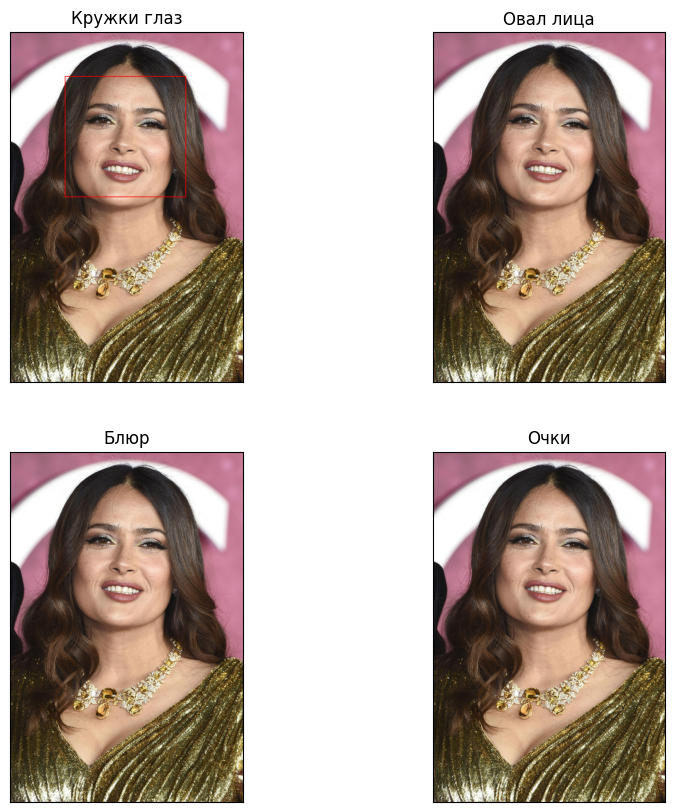

In [73]:
# Вывод изображений

fig, axes = pyplot.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])
axes[0, 0].set_title('Кружки глаз')

axes[0, 1].imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])
axes[0, 1].set_title('Овал лица')

axes[1, 0].imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])
axes[1, 0].set_title('Блюр')

axes[1, 1].imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])
axes[1, 1].set_title('Очки')

pyplot.show()